In [1]:
# ALL IMPORTS
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import tensorflow as tf
from random import shuffle
import librosa
import pickle


In [2]:
# LOAD PROCESSED DATA
stackedTraining_Data, stackedTraining_Label = pickle.load(open('preprocessedAudio_Training_MNIST.p', mode='rb'))
stackedValidation_Data, stackedValidation_Label = pickle.load(open('preprocessedAudio_Validation_MNIST.p', mode='rb'))


In [3]:
# CREATE VARIABLES RELATED TO DATA
numberOfClasses = len(stackedTraining_Label[0])
batch_size = 64

nOfBatches_Train = int(len(stackedTraining_Data)/batch_size)
nOfBatches_Valid = int(len(stackedValidation_Data)/batch_size)


In [4]:
# STRUCTURE CONV LAYER
def conv2D(inputTensor, outputTensor, kernelSize, strideSize):
    # CREATE WEIGHTS WITH STD 0.05
    weights = tf.Variable(tf.truncated_normal([kernelSize,kernelSize, int(inputTensor.shape[3]), outputTensor],stddev=.05))
    # CREATE CONV LAYER
    inputTensor = tf.nn.conv2d(inputTensor, weights, strides = [1,strideSize,strideSize,1],padding = 'SAME')
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputTensor]))
    # ADD BIAS TO OUTCOME OF CONV
    inputTensor = tf.nn.bias_add(inputTensor, bias)
    # RETURN ACTIVATION AS RELU
    return tf.nn.relu(inputTensor)

In [5]:
# STRUCTURE MAXPOOLING LAYER WITH PADDING = SAME
def maxPool(inputTensor, kernelSize, strideSize):
    # RETURN MAXPOOL
    return tf.nn.max_pool(inputTensor,ksize = [1,kernelSize,kernelSize,1],strides = [1,strideSize,strideSize,1],padding = 'SAME')

In [6]:
# STRUCTURE FULLY CONNECTED LAYER
def fcl(inputTensor, outputNodes):
    # He initialisation
    inputNodes = int(inputTensor.shape[1])
    # HE INITIALISATION NOT USED
    sig = 0.05 #np.sqrt(2/inputNodes)
    # CREATE WEIGHTS
    weights = tf.Variable(tf.truncated_normal([inputNodes, outputNodes], stddev=sig))
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputNodes]))
    # MULTIPLY INPUT BY WEIGHTS AND ADD BIAS
    inputTensor = tf.add(tf.matmul(inputTensor, weights), bias)
    # RETURN ACTIVATION AS RELU
    return tf.nn.relu(inputTensor)

In [7]:
# STRUCTURE OUTPUT LAYER - THIS IS NEEDED CAUSE LAST LAYER IS SOFTMAX ACTIVATION
def output(inputTensor, outputNodes):
    inputNodes = int(inputTensor.shape[1])
    # CREATE WEIGHTS
    weights = tf.Variable(tf.truncated_normal([inputNodes, outputNodes], stddev=0.05))
    # CREATE BIAS
    bias = tf.Variable(tf.zeros([outputNodes]))
    # RETURN MULTIPLIED WEIGHTS, INPUT AND ADDED BIAS
    return tf.add(tf.matmul(inputTensor, weights), bias)

In [8]:
# FLATTEN THE OUTPUT OF THE CONV NET TO GET FEATURES AS 1D ARRAY
def dense(inputTensor):
    inputShape = inputTensor.get_shape().as_list()
    return tf.reshape(inputTensor, [-1, inputShape[1] * inputShape[2] * inputShape[3]])

In [9]:
# STRUCTURE THE WHOLE INITIAL CONVOLUTIONAL NET
def conv2DNet(inputTensor, keep_prob):
    print("CONV")
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 32, 5,1) 
    inputTensor = maxPool(inputTensor, 3,2) 

    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 64, 4,1) 
    inputTensor = maxPool(inputTensor, 2,2) 
    
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 64, 3,1) 
    inputTensor = maxPool(inputTensor,  2,2) 
    
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 128, 3,1) 
    inputTensor = maxPool(inputTensor, 2,2) 
    
    print(inputTensor.shape)
    inputTensor = conv2D(inputTensor, 256, 3,1) 
    inputTensor = maxPool(inputTensor,  2,2) 
    
    # ADD DROPOUT
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    # DENSE / FLATTEN
    inputTensor = dense(inputTensor)
    print(inputTensor.shape)
    # RETURN OUTPUT OF CONV
    return inputTensor

# CREATE THE MLP STRUCTURE
def mlp(inputTensor, keep_prop):
    print("MLP")
    inputTensor = fcl(inputTensor, 1024)
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    print(inputTensor.shape)
    inputTensor = fcl(inputTensor, 1024)
    inputTensor = tf.nn.dropout(inputTensor, keep_prob)
    print(inputTensor.shape)
    # RETURN OUTPUT OF MLP
    return output(inputTensor, numberOfClasses)


In [10]:
# RESET GRAPH/WEIGHTS FOR RETRAINING
tf.reset_default_graph()
# EPOCHS TO TRAIN FOR
epochs = 60
# DROPOUT PROPABILITY
keep_probability = 0.5

# VARIABLES FOR GRAPH
# NONE = BATCH SIZE PRESENTED TO GRAPH
x = tf.placeholder(tf.float32, [None, 128, 44, 1], name="x")
y = tf.placeholder(tf.float32, [None, numberOfClasses], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# CONVOLUTIONAL LOGIT - SAVED 
conv_logit = conv2DNet(x, keep_prob)
conv_logit = tf.identity(conv_logit, name='convLogits')

# MLP LOGIT - SAVED
mlp_logit = mlp(conv_logit, keep_prob)
mlp_logit = tf.identity(mlp_logit, name='mlpLogits')

# COST FUNCTION AND OPTIMIZER INITIALIZED
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=mlp_logit, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# PREDICTION AND ACCURACY FUNCTION
correct_pred = tf.equal(tf.argmax(mlp_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


CONV
(?, 128, 44, 1)
(?, 64, 22, 32)
(?, 32, 11, 64)
(?, 16, 6, 64)
(?, 8, 3, 128)
(?, 2048)
MLP
(?, 1024)
(?, 1024)


In [165]:
# THE TRAINING LOOP
import time
start_time = time.time()

print("Start Training")
# LR IS DEFAULT ADAM - learning_rate=0.001

# ARRAYS FOR GRAPH
trainCost = []
trainAcc = []
validCost = []
validAcc = []

with tf.Session() as sess:
    # INIT ALL VARIABLES
    sess.run(tf.global_variables_initializer())
    # SET TRAINING DATA
    data = stackedTraining_Data
    targetVector = stackedTraining_Label
    # SET VALIDATION DATA
    dataVal = stackedValidation_Data
    targetVectorVal = stackedValidation_Label
    # SET THE BATCHES
    trainBatch = nOfBatches_Train+1
    validBatch = nOfBatches_Valid+1
    # TRAIN FOR EPOCHS
    for epoch in range(1,epochs+1):
        print('Start Epoch ' + str(epoch))
        
        # TRAIN 
        avgLossHolder = 0
        avgAccHolder = 0
        for i in range(trainBatch): 
            batch_x = data[i*batch_size:(i+1)*batch_size]
            batch_y = targetVector[i*batch_size:(i+1)*batch_size]
            
            # RUN THE OPTIMIZER
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
            # GET THE LOSS AND ACCURACY
            currTrainLoss, currTrainAcc = sess.run([cost,accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            avgLossHolder += currTrainLoss
            avgAccHolder += currTrainAcc
        
        avgLossHolder /= trainBatch
        avgAccHolder /= trainBatch
        trainCost.append(avgLossHolder)
        trainAcc.append(avgAccHolder)
        print('Loss: {:>8.4f}, Training Accuracy: {:>8.6f}'.format(avgLossHolder, avgAccHolder))
        
        # VALIDATION
        avgLossHolder = 0
        avgAccHolder = 0

        for i in range(validBatch): 
            batch_x = dataVal[i*batch_size:(i+1)*batch_size]
            batch_y = targetVectorVal[i*batch_size:(i+1)*batch_size]
            # GET THE LOSS AND ACCURACY
            currValidLoss, currValidAcc = sess.run([cost,accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            avgLossHolder += currValidLoss
            avgAccHolder += currValidAcc
        
        avgLossHolder /= validBatch
        avgAccHolder /= validBatch
        validCost.append(avgLossHolder)
        validAcc.append(avgAccHolder)
        
        print('Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}'.format(avgLossHolder, avgAccHolder))
        print('Epoch ' + str(epoch) + ' done')

    print("Training done - took %s seconds" % (time.time() - start_time))            

    # SAVE THE MODEL
    saver = tf.train.Saver()
    save_path = saver.save(sess, './audio_classificationMNIST')
    
 

Start Training
Start Epoch 1
Loss:   2.1479, Training Accuracy: 0.177262
Loss:   1.8671, Validation Accuracy: 0.292209
Epoch 1 done
Start Epoch 2
Loss:   1.5460, Training Accuracy: 0.420337
Loss:   1.3788, Validation Accuracy: 0.532395
Epoch 2 done
Start Epoch 3
Loss:   1.0929, Training Accuracy: 0.604246
Loss:   1.0075, Validation Accuracy: 0.655451
Epoch 3 done
Start Epoch 4
Loss:   0.8449, Training Accuracy: 0.699901
Loss:   0.7620, Validation Accuracy: 0.743169
Epoch 4 done
Start Epoch 5
Loss:   0.7085, Training Accuracy: 0.753244
Loss:   0.7427, Validation Accuracy: 0.747912
Epoch 5 done
Start Epoch 6
Loss:   0.6123, Training Accuracy: 0.790139
Loss:   0.6421, Validation Accuracy: 0.777325
Epoch 6 done
Start Epoch 7
Loss:   0.5573, Training Accuracy: 0.809692
Loss:   0.5699, Validation Accuracy: 0.809027
Epoch 7 done
Start Epoch 8
Loss:   0.4996, Training Accuracy: 0.831726
Loss:   0.5573, Validation Accuracy: 0.815098
Epoch 8 done
Start Epoch 9
Loss:   0.4546, Training Accuracy: 

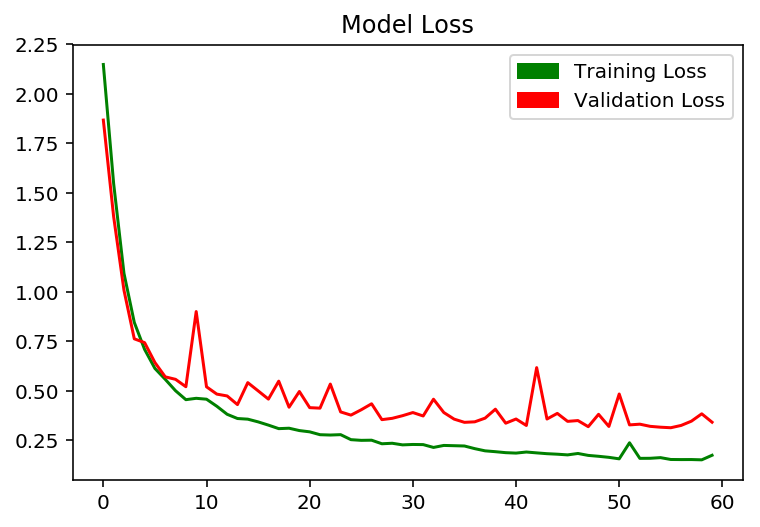

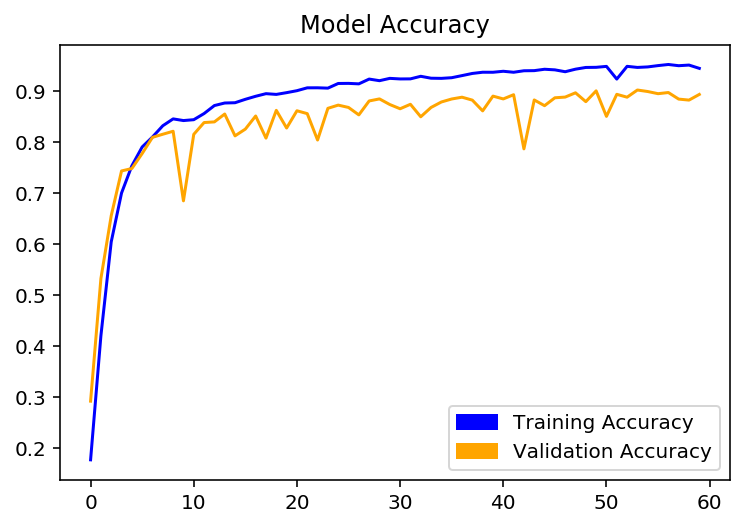

In [166]:
# PLOT THE ACCURACY AND COST
# COST
plt.figure(1)
plt.plot(trainCost, color='g', alpha=1)
plt.plot(validCost, color='r', alpha=1)
plt.title('Model Loss')
green = mpatches.Patch(color='green', label='Training Loss')
red = mpatches.Patch(color='red', label='Validation Loss')
plt.legend(handles=[green,red])
plt.show()
# ACCURACY
plt.figure(2)
plt.plot(trainAcc, color='b', alpha=1)
plt.plot(validAcc, color='orange', alpha=1)
plt.title('Model Accuracy')
blue = mpatches.Patch(color='b', label='Training Accuracy')
orange = mpatches.Patch(color='orange', label='Validation Accuracy')
plt.legend(handles=[blue,orange])
plt.show()